# Table Data Preprocessing: Adults dataset

## Introduction

The dataset we will explore in this notebook comes from the UCI Machine Learning Repository. The dataset, titled 'Adult', was donated to the repository in 1996 by Ronny Kohavi and Barry Becker. It contains an extract from the 1994 U.S. census comprising a subset of individual-level characteristics along with income, with the purpose of predicting whether an individual has an annual income of greater than $50,000.

From a social science perspective, the data can help us understand relationships between an individual's background, race, occupation, and numerous other characteristics and her annual income. It could also illuminate social inequities such as racial or class disparities in income. Of course, given the data set's age, the data is unlikely to accurately reflect our current society, thus it mainly serves as a useful dataset from which to practice machine learning/statistics algorithms.

Ultimately, for a prediction algorithm to be at all useful, it must at least achieve a greater percentage of accuracy than the proportion of individuals belonging to the majority class (i.e., if 80% of individuals earn less than $50K, the algorithm must be able to predict with greater than 80% accuracy to be effective).

We can observe the proportion of observations belonging to the majority class once we import the data and explore some of its features, so let's do that now.

## Exploring the Data


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
import missingno as mn

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Plot settings
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 16

In [2]:
# Load data from disk
file = "data/adult.data.txt"
headers = ["age", "workclass", "fnlwgt", "education", "education_num",
          "marital_status", "occupation", "relationship", "race",
          "sex", "capital_gain", "capital_loss", "hours_per_week",
          "native_country", "earnings"]
df = pd.read_csv(file, header=None, names=headers, skipinitialspace=True)

# View the first five instances of the data set
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We can first get a sense of the data set by simply examining its dimensions.

In [3]:
df.shape

(32561, 15)

So there are 32,561 instances and 14 features (one of the columns contains the class label). Let's dig further into each feature.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
earnings          32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We have a mix of categorical features (denoted as 'object') and numeric/continuous features ('int64'). Based on the info method, it appears that there are also no missing values, although this can be misleading if missing values are specified as a data type other than Numpy's <code>NaN</code>. We'll explore this in greater detail in the next section.

For now, it makes sense to describe each feature in a little bit greater detail.

##### Discrete/Categorical Features (+ Class Label)

In [5]:
pd.options.display.max_colwidth = 0 # allow long strings to wrap to next line in HTML table

# Create table describing each feature in greater detail
table_cat = pd.DataFrame()
table_cat['Features'] = df.select_dtypes(include=[object]).columns
table_cat['Type'] = ['Nominal'] * 6 + ['Binary', 'Nominal', 'Binary']
table_cat['Values'] = pd.Series()

table_cat.Values = [df[i].unique() for i in table_cat.Features]

# Print table
table_cat

,Features,Type,Values
0,workclass,Nominal,"[State-gov, Self-emp-not-inc, Private, Federal-gov, Local-gov, ?, Self-emp-inc, Without-pay, Never-worked]"
1,education,Nominal,"[Bachelors, HS-grad, 11th, Masters, 9th, Some-college, Assoc-acdm, Assoc-voc, 7th-8th, Doctorate, Prof-school, 5th-6th, 10th, 1st-4th, Preschool, 12th]"
2,marital_status,Nominal,"[Never-married, Married-civ-spouse, Divorced, Married-spouse-absent, Separated, Married-AF-spouse, Widowed]"
3,occupation,Nominal,"[Adm-clerical, Exec-managerial, Handlers-cleaners, Prof-specialty, Other-service, Sales, Craft-repair, Transport-moving, Farming-fishing, Machine-op-inspct, Tech-support, ?, Protective-serv, Armed-Forces, Priv-house-serv]"
4,relationship,Nominal,"[Not-in-family, Husband, Wife, Own-child, Unmarried, Other-relative]"
5,race,Nominal,"[White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other]"
6,sex,Binary,"[Male, Female]"
7,native_country,Nominal,"[United-States, Cuba, Jamaica, India, ?, Mexico, South, Puerto-Rico, Honduras, England, Canada, Germany, Iran, Philippines, Italy, Poland, Columbia, Cambodia, Thailand, Ecuador, Laos, Taiwan, Haiti, Portugal, Dominican-Republic, El-Salvador, France, Guatemala, China, Japan, Yugoslavia, Peru, Outlying-US(Guam-USVI-etc), Scotland, Trinadad&Tobago, Greece, Nicaragua, Vietnam, Hong, Ireland, Hungary, Holand-Netherlands]"
8,earnings,Binary,"[<=50K, >50K]"


##### Continuous/Numerical Features

In [6]:
pd.options.display.max_colwidth = 0 # allow long strings to wrap to next line in HTML table

table_num = df.describe().T.round()
table_num['Description'] = ['age of individual',
                           'survey weights (people with similar demographic characteristics should have similar weights)',
                           'years of education',
                           'income from investment sources',
                           'losses from investment sources',
                           'hours worked per week']
table_num['Type'] = ['Ratio', 'Interval', 'Ratio', 'Ratio', 'Ratio', 'Ratio']


# Print table
table_num

,count,mean,std,min,25%,50%,75%,max,Description,Type
age,32561.0,39.0,14.0,17.0,28.0,37.0,48.0,90.0,age of individual,Ratio
fnlwgt,32561.0,189778.0,105550.0,12285.0,117827.0,178356.0,237051.0,1484705.0,survey weights (people with similar demographic characteristics should have similar weights),Interval
education_num,32561.0,10.0,3.0,1.0,9.0,10.0,12.0,16.0,years of education,Ratio
capital_gain,32561.0,1078.0,7385.0,0.0,0.0,0.0,0.0,99999.0,income from investment sources,Ratio
capital_loss,32561.0,87.0,403.0,0.0,0.0,0.0,0.0,4356.0,losses from investment sources,Ratio
hours_per_week,32561.0,40.0,12.0,1.0,40.0,40.0,45.0,99.0,hours worked per week,Ratio


Returning to our earlier discussion of baseline prediction accuracy, our prediction algorithm(s) must exceed the proportion of instances belonging to the majority class in order for us to consider our model predictive.

In [7]:
# Determine majority class membership
df['earnings'].value_counts()[0] / df.shape[0]

0.75919044255397561

So assuming we do not remove any instances due to missing values, our baseline prediction accuracy is 75.9%.

### Ensuring Data Quality

Before we continue with our analysis, it is important to ensure we are working with a clean data set. This means we want to check for three things:
* duplicate instances
* missing values
* extreme/unlikely values

If we identify missing or extreme values, we must then decide whether we want to remove the instances altogether or impute the values.

Let's begin with identifying duplicate instances.

In [8]:
# Number of duplicated rows (excluding the first instance of the row)
len(df[df.duplicated(keep='first')])

24

Unfortunately, the data dictionary that the dataset authors helpfully provided indicates that there are just 6 duplicated instances in total. With that said, the duplicated instances all have the same value for *fnlwgt*, which, as far as we can tell, is a continuous variable and unlikely to ever have duplicate values. For this reason, we have decided to remove all of the duplicated values.

In [9]:
# Examine the duplicated values
df[df.duplicated(keep=False)].sort_values(by='fnlwgt')

# Remove duplicate values
df.drop_duplicates(keep=False, inplace=True)

Next, we check for missing values. Although the <code>NumPy</code> <code>info</code> method earlier indicated that there are no null values in the dataset, this simply means that there are no <code>NaN</code> values. In fact, upon further examination of the data (and, again, the data dictionary), it is clear that missing values were coded with the "?" character. Let's go ahead and replace these with a value <code>NumPy</code> can recognize.

In [10]:
# Replace missing values (denoted by "?") with NaN
df = df.replace("?", np.NaN)

# Number of missing values per feature
df.isnull().sum()

age               0   
workclass         1836
fnlwgt            0   
education         0   
education_num     0   
marital_status    0   
occupation        1843
relationship      0   
race              0   
sex               0   
capital_gain      0   
capital_loss      0   
hours_per_week    0   
native_country    581 
earnings          0   
dtype: int64

We now know that three of our features contain instances with missing values, but we do not know whether these values represent the same instances. For instance, *workclass* and *occupation* have similar numbers of missing values. If the same instances are missing values for both of these features, this may provide us some meaningful information about those instances (e.g., perhaps these individuals were between jobs and opted not to fill out that portion of the census). 

Fortunately, we can quickly visualize all of our missing data and identify patterns of missingness using the handy <code>missingno</code> package provided by *ResidentMario* (source: https://github.com/ResidentMario/missingno). Missing values appear in white, whereas true values appear in dark gray.

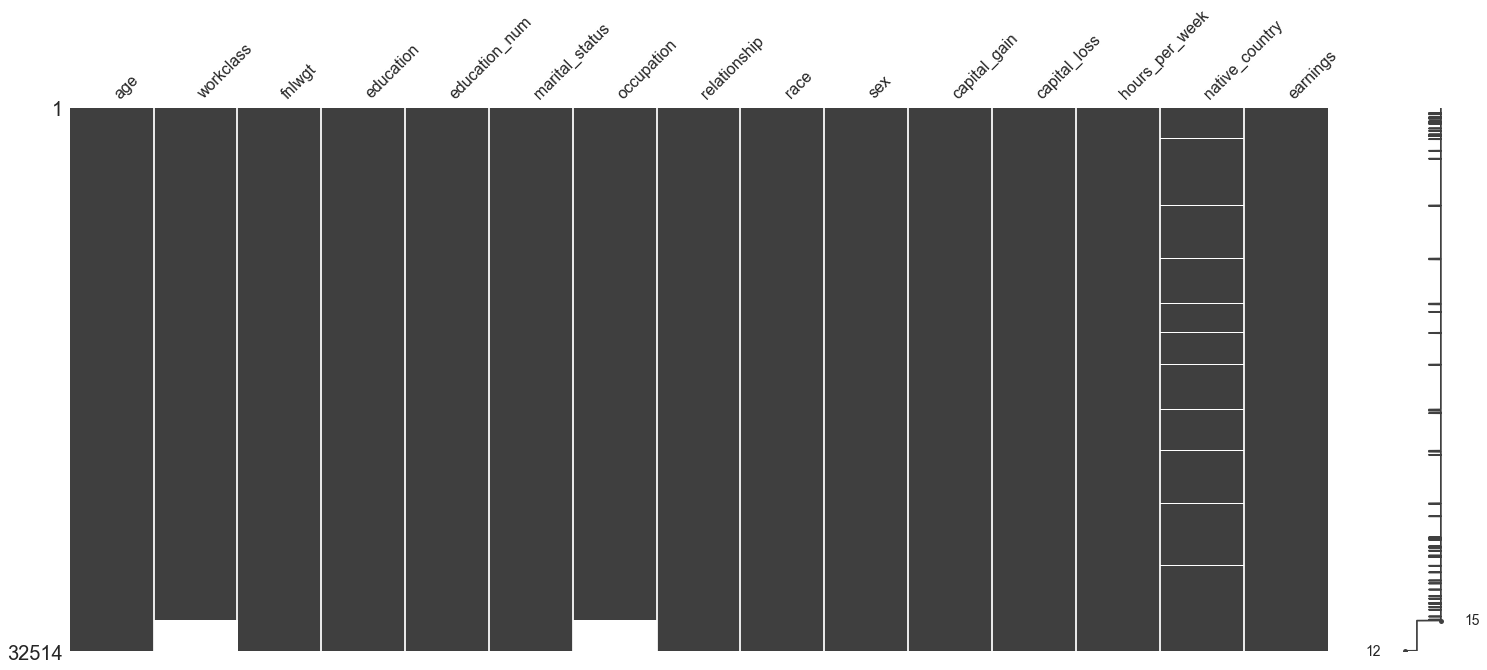

In [11]:
# Impute
mn.matrix(df.sort_values(by=["workclass","occupation","native_country"]))

As we suspected, the features *workclass* and *occupation* have missing values for roughly the same instances, whereas *native_country* has more or less random missingness. Since these are categorical features, we can recode all of the missing values for *workclass* and *occupation* as a new category, *Unknown*, and preserve whatever latent similarities these instances may possess (rather than making an assumption and imputing with the most frequent category).

In [12]:
# Recode missing values for workclass and occupation as 'Unknown'
df['workclass'].fillna('Unknown', inplace=True)
df['occupation'].fillna('Unknown', inplace=True)

For *native_country*, it's helpful to understand the data a little better before we make an imputation decision.

In [13]:
df.native_country.value_counts()

United-States                 29136
Mexico                        635  
Philippines                   198  
Germany                       137  
Canada                        121  
Puerto-Rico                   114  
El-Salvador                   106  
India                         100  
Cuba                          95   
England                       90   
Jamaica                       81   
South                         80   
China                         75   
Italy                         73   
Dominican-Republic            70   
Vietnam                       67   
Japan                         62   
Guatemala                     61   
Poland                        60   
Columbia                      59   
Taiwan                        51   
Haiti                         44   
Iran                          43   
Portugal                      37   
Nicaragua                     34   
Peru                          31   
France                        29   
Greece                      

Most of the instances have the United States for their native country. Because of the heavy density for the US, it is probably safe to recode the missing values for this feature with the mode, which would be the US.

The only other change we will make here is to group the one instance from The Netherlands in with Germany, as using only one instance in a category to make a prediction will increase the variance of our model without adding any predictive value.

In [14]:
# Recode missing values with 'United States'
df['native_country'].fillna('United-States', inplace=True)
# Recode Holand-Netherlands as Germany
df['native_country'] = df['native_country'].replace('Holand-Netherlands', 'Germany')

NUMERIC IMPUTATION:
Often during data collection for surveys, missing values are coded differently to represent different types of missingness. For example, 0 could signify that there was no response; -1 that a person declined to answer; 99999 could signify that the person did not understand the question; -99999 could signify that the person did not have time to answer the question, etc. If the analyst is not careful, this numerical coding could filter through the analysis and add bias to the results.  

Furthermore, when developing statistical models, one would like for the predictions to generalize to the majority of the population. While some algorithms are robust and can handle the presence of outliers, models that make assumptions about the underlying distribution of the population tend to be sensitive to outliers. Although outliers are certainly part of the population of interest, their presence tends to skew the predictions, therefore reducing the predictive power of the statistical model. It is generally good practice to define the population of interest as much as possible and deal with outliers on a case by case basis.

A good way to deal with these kind of issues is to examine the five number summary of the numeric variables as well as the histograms.  

In [15]:
table_num

,count,mean,std,min,25%,50%,75%,max,Description,Type
age,32561.0,39.0,14.0,17.0,28.0,37.0,48.0,90.0,age of individual,Ratio
fnlwgt,32561.0,189778.0,105550.0,12285.0,117827.0,178356.0,237051.0,1484705.0,survey weights (people with similar demographic characteristics should have similar weights),Interval
education_num,32561.0,10.0,3.0,1.0,9.0,10.0,12.0,16.0,years of education,Ratio
capital_gain,32561.0,1078.0,7385.0,0.0,0.0,0.0,0.0,99999.0,income from investment sources,Ratio
capital_loss,32561.0,87.0,403.0,0.0,0.0,0.0,0.0,4356.0,losses from investment sources,Ratio
hours_per_week,32561.0,40.0,12.0,1.0,40.0,40.0,45.0,99.0,hours worked per week,Ratio


From this table, there are 3 things that need to be further inspected:
- The maximum final weight seems to be several times larger than the 75th percentile, whereas this difference is not true among lower percentiles. Either these values are outliers, or they are the result of an input error. Either way, the cases should be examined in detail.

Investigating the distribution with a histogram reveals that there are other values close to the max. The variable *final weight* is supposed to represent demographic characteristics (according to the data dictionary), therefore it is expected that the population would behave similarly to the sample.

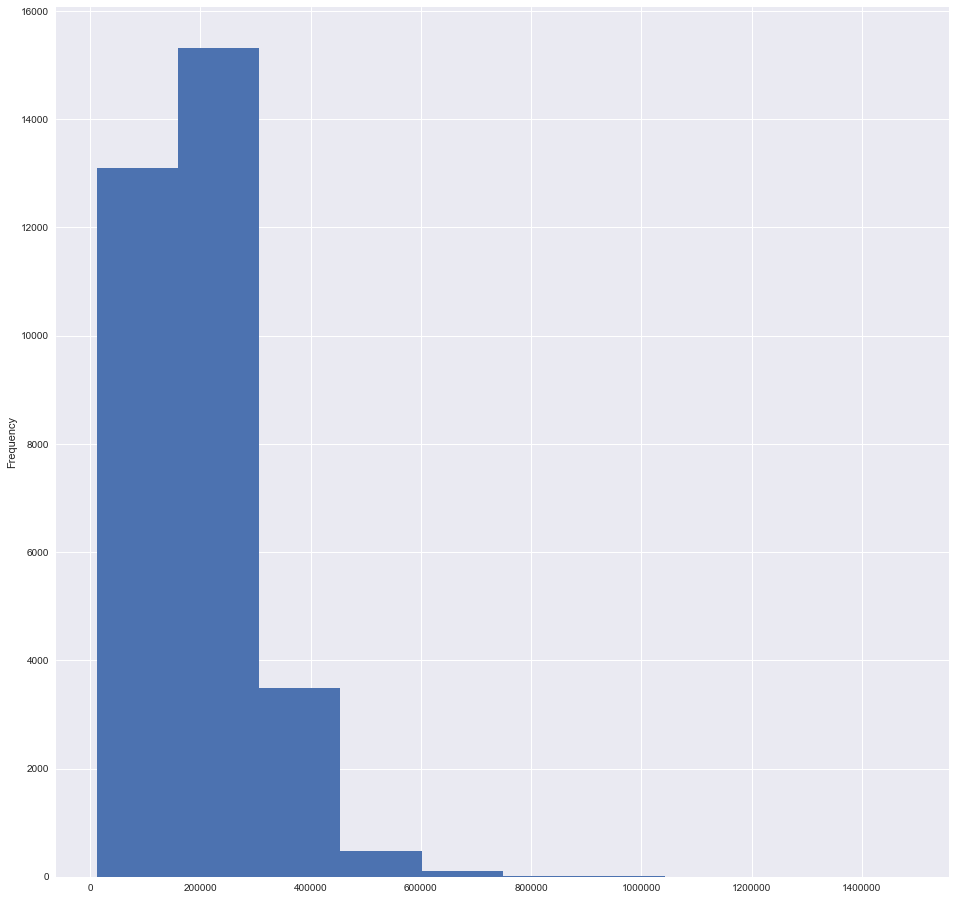

In [16]:
df.fnlwgt.plot(kind="hist")
plt.show()

- The maximum value for capital gain is 99999 which should raise some flags. Furthermore, the difference between the max and the 75 percentile is significant. As before, this could be a missing value, an input error, the result of censored data (i.e. partially known), or perhaps the input field only allowed a max of 5 digits.

As with the weights, we begin by analyzing the sample distribution and comparing it to the expected distribution. We would expect for the majority of the population to have limited or no capital gain while only a handful of them having significant capital gain.

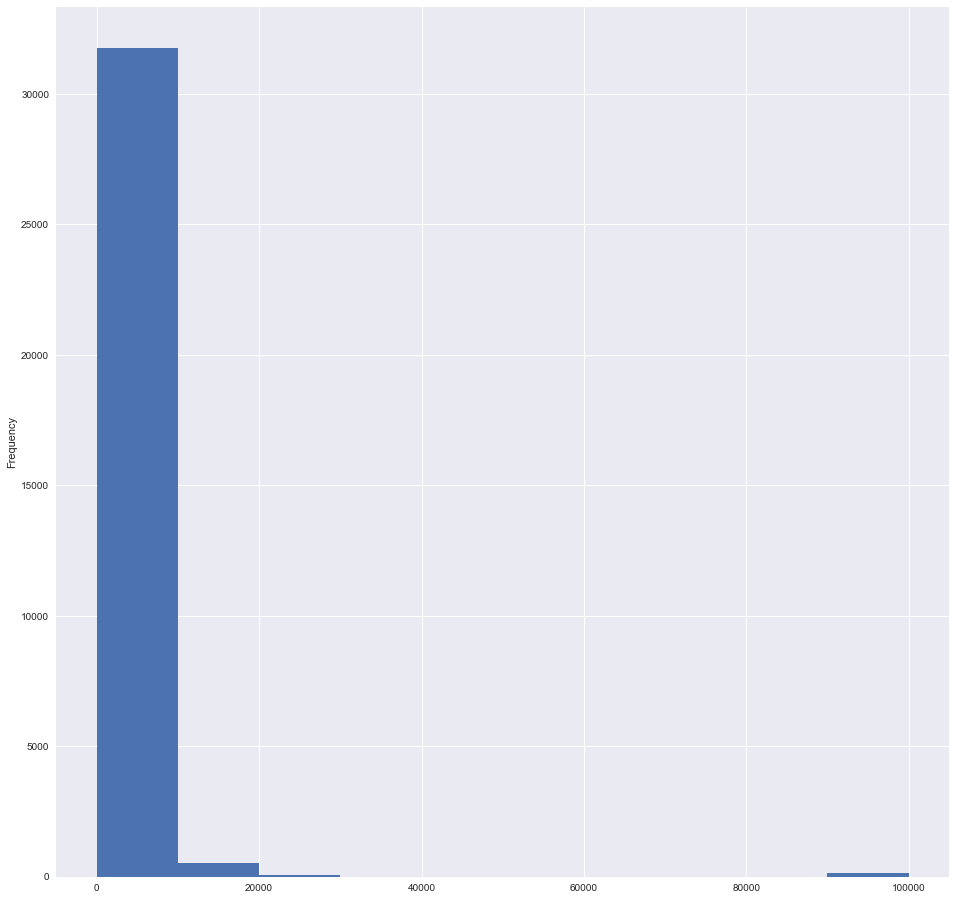

In [17]:
df.capital_gain.plot(kind="hist")
plt.show()

Is this data consistent? We would expect for this handful of people earning almost 50k in capital gain to have reported earnings above 50k.

In [18]:
df["capital_gain_group"] = pd.cut(df.capital_gain, bins = [0,0.5,5000,50000,100000], 
                    include_lowest=True, 
                    labels=["no gain", "small gain", "moderate gain", "significant gain"])

pd.crosstab(df.capital_gain_group,
            df.earnings)

earnings,<=50K,>50K
capital_gain_group,,
moderate gain,152,1337
no gain,23642,6160
significant gain,0,159
small gain,883,181


After binning the capital gain and cross-tabulating with earnings, we can see that the individuals that reported significant capital gains (above 50k) also reported earning above 50k per year. While this seems to suggest that the values are not missing, it is likely that the values are right-censored. Since we do not know the real values for capital earnings, we may use the ordinal variable.

  
- The maximum capital loss behaves similarly to the maximum capital gain. Although we can eliminate the probability of censored data, it is important to investigate these values.

Similarly to how we handled *capital gain*, we analyze the distribution of *capital loss*. We would expect for the majority of the population to have limited or no capital loss, while only a handful of them would have significant capital gain. The histogram below shows this to be the case.

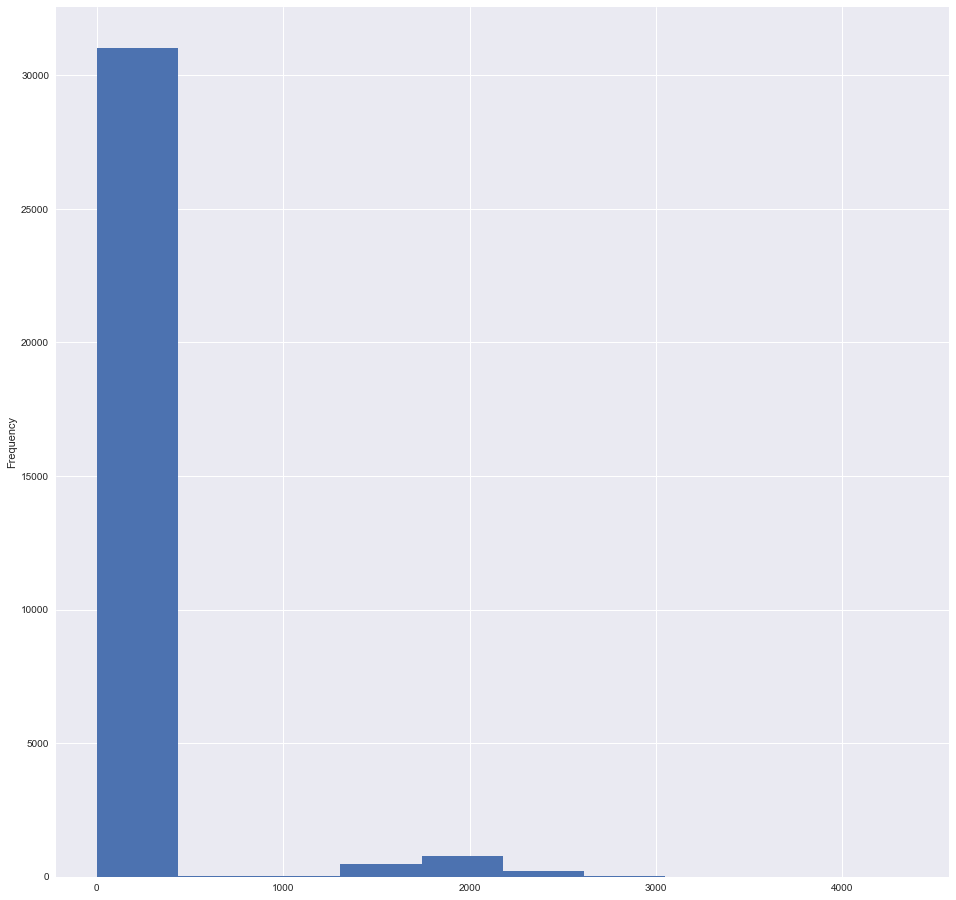

In [19]:
df.capital_loss.plot(kind="hist")
plt.show()

In [20]:
df["capital_loss_group"] = pd.cut(df.capital_loss, bins = [0,0.5,500,1000,5000], 
                    include_lowest=True, 
                    labels=["no loss", "small loss", "moderate loss", "significant loss"])
pd.crosstab([df.capital_loss_group, df.capital_gain_group],
            df.earnings)
           

earnings                               <=50K  >50K
capital_loss_group capital_gain_group             
moderate loss      moderate gain       0      0   
                   no gain             23     2   
                   significant gain    0      0   
                   small gain          0      0   
no loss            moderate gain       152    1337
                   no gain             22896  5387
                   significant gain    0      159 
                   small gain          883    181 
significant loss   moderate gain       0      0   
                   no gain             712    771 
                   significant gain    0      0   
                   small gain          0      0   
small loss         moderate gain       0      0   
                   no gain             11     0   
                   significant gain    0      0   
                   small gain          0      0

The jittered scatter plot by groups serves two purposes:
- It shows us the density per *investment group* and their earnings. We can see that everyone with significant capital gain has earnings above 50k.
- It shows us that no person with reported capital gains has capital losses.

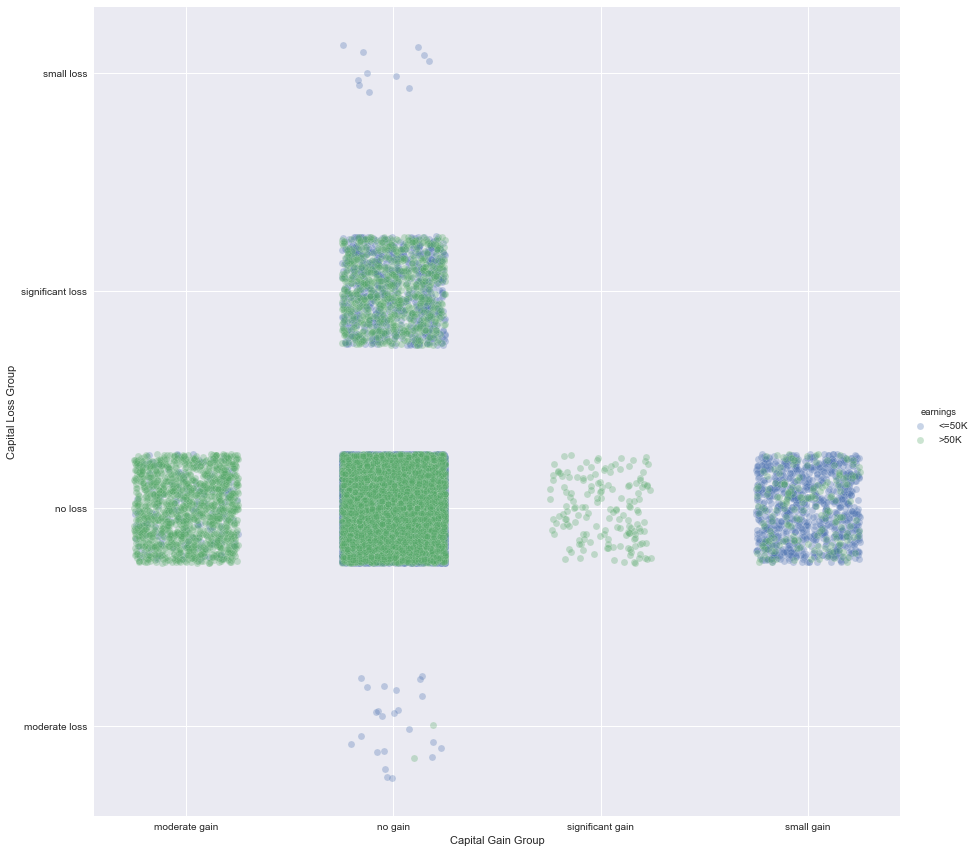

In [21]:
df_plot = df[["capital_gain_group", "capital_loss_group", "earnings"]]
df_plot["capital_gain_group"] = df_plot.capital_gain_group.cat.codes+np.random.rand(len(df))/2
df_plot["capital_loss_group"] = df_plot.capital_loss_group.cat.codes+np.random.rand(len(df))/2

g = sns.pairplot(x_vars = ["capital_gain_group"],  y_vars = ["capital_loss_group"],
             data = df_plot,
             hue = "earnings",
             plot_kws={'alpha':0.3},
             size =12)
plt.xlabel("Capital Gain Group")
plt.ylabel("Capital Loss Group")
g.set(xticklabels = df.capital_gain_group.cat.categories, xticks = [0.25, 1.25, 2.25, 3.25],
      yticklabels = df.capital_loss_group.cat.categories, yticks = [0.25, 1.25, 2.25, 3.25])

plt.show()

- The maximum hour per week is a staggering 99. Although completely plausible, this is unlikely (even more if the data was censored). This may be an input error or a missing value, and thus is something we should be mindful of as we continue with our analysis.

Finally the histogram of the hours worked should shine some light regarding the value 99 which we suspect is a censored value.

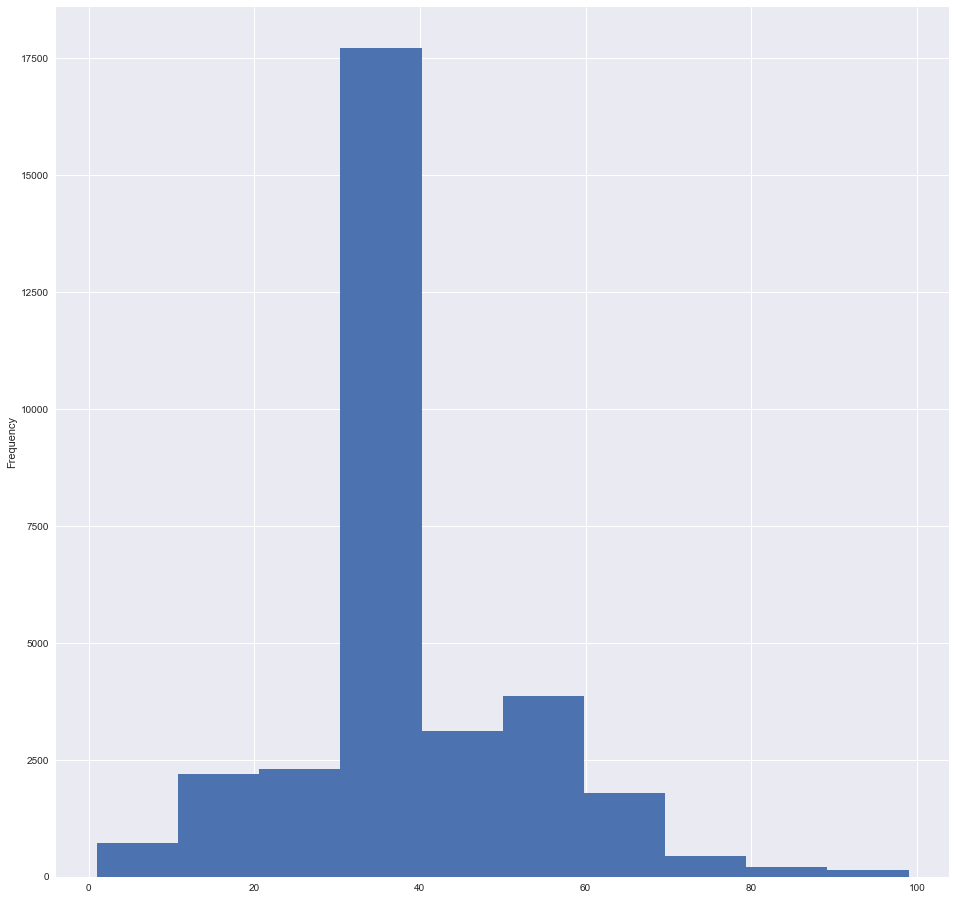

In [22]:
df.hours_per_week.plot(kind="hist")
df.hours_per_week.value_counts().sort_index().tail()
plt.show()

Age, as expected, seems to follow a truncated distribution bounded by 0 and 99. There are around 85 persons reporting working at least 99 hours per week. This is another indication that age has been truncated; to allow for easier analysis, we group the hours per week variable.

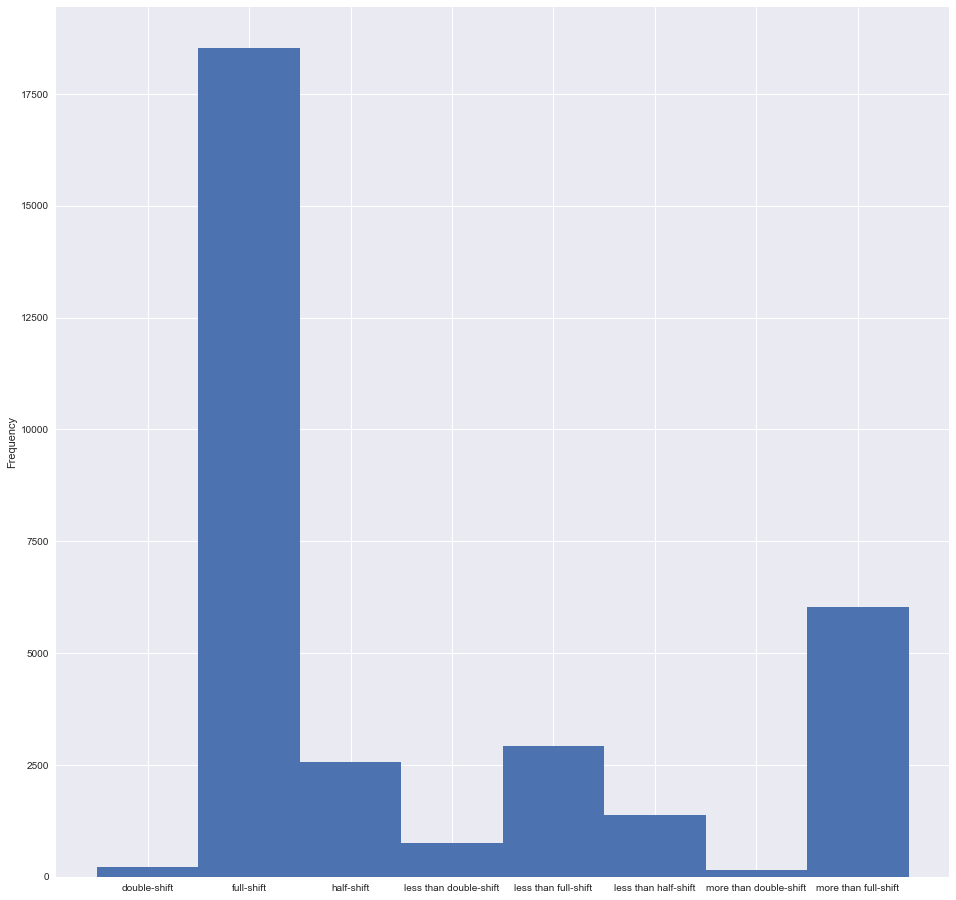

In [23]:
df["hours_per_week_group"] = pd.cut(df.hours_per_week, bins = [0,15,25,35,45,60,75,85,100], 
                    include_lowest=True, 
                    labels=["less than half-shift",
                            "half-shift",
                            "less than full-shift",
                            "full-shift",
                            "more than full-shift",
                            "less than double-shift",
                            "double-shift",
                            "more than double-shift"
                           ])

ax = df.hours_per_week_group.cat.codes.plot(kind="hist", bins=8)
ax.set_xticklabels(df.hours_per_week_group.cat.categories)
ax.set_xticks(np.arange(7/16, 7, 7/8))
plt.show()

In [24]:
df_train = df.drop(["capital_gain", "capital_loss", "hours_per_week", "fnlwgt"], axis=1)
df_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,earnings,capital_gain_group,capital_loss_group,hours_per_week_group
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,small gain,no loss,full-shift
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,no gain,no loss,less than half-shift
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K,no gain,no loss,full-shift
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K,no gain,no loss,full-shift
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K,no gain,no loss,full-shift


## Visualizing the Data

### Univariate Distributions

For continuous features, we examine histograms to ensure we have accounted for unusual values and gain a better intuition for the underlying distributions of the data. We review bar charts for categorical features to find out if a particular category is heavily associated with one particular class.

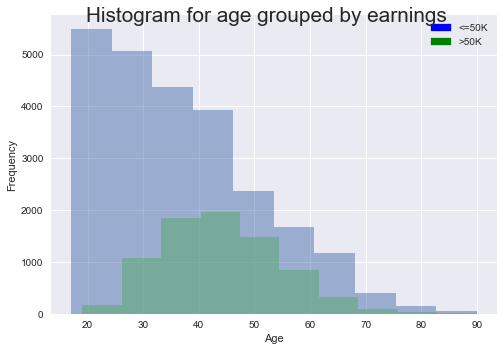

In [25]:
sns.set()
df.groupby('earnings').age.hist(alpha=0.5)
plt.suptitle('Histogram for age grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Age')
plt.ylabel('Frequency')
blue_patch = mpatches.Patch(color='blue', label='<=50K')
green_patch=mpatches.Patch(color='green', label=">50K")
plt.legend(handles=[blue_patch,green_patch])

The histogram shows that for the group of people earning less than or equal to 50K, the histogram is right-skewed. this means that there are more younger people than older people who are earning less than or equal to 50K. On the other hand, the group of people earning greater than 50K per year are distributed fairly normally.

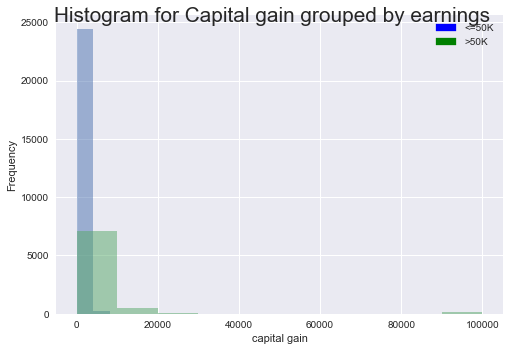

In [26]:
df.groupby('earnings').capital_gain.hist(alpha=0.5)
plt.suptitle('Histogram for Capital gain grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('capital gain')
plt.ylabel('Frequency')
blue_patch = mpatches.Patch(color='blue', label='<=50K')
green_patch=mpatches.Patch(color='green', label=">50K")
plt.legend(handles=[blue_patch,green_patch])

The histogram for capital gain shows that the capital gain for all people earning <=50K is either 0 or very small, whereas the capital gain for people earning >50K is on the higher side with a right skewed distribution. However, there seem to be few values between 80000 and 100000, which might be due to incorrectly collected data or cencored data. 

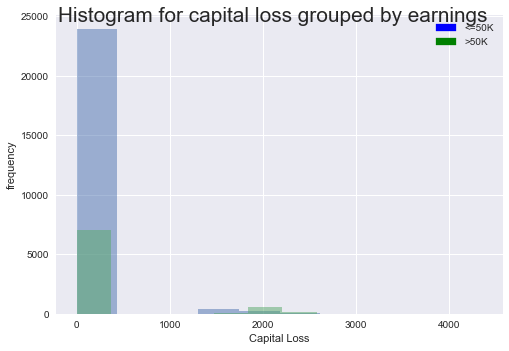

In [27]:
df.groupby('earnings').capital_loss.hist(alpha=0.5)
plt.suptitle('Histogram for capital loss grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Capital Loss')
plt.ylabel('frequency')
blue_patch = mpatches.Patch(color='blue', label='<=50K')
green_patch=mpatches.Patch(color='green', label=">50K")
plt.legend(handles=[blue_patch,green_patch])

Similar to the capital gain, the capital loss, for people in the group earning<=50K is either 0 or very small with exceptions for a few values between 1,000 and 2,000. The capital loss for the group earning >50K is small as well, having a few values between 1,500 and 3,000. Hence the histograms for both the groups are right skewed. Again these values might be due to incorrect collection of data or cencored data.

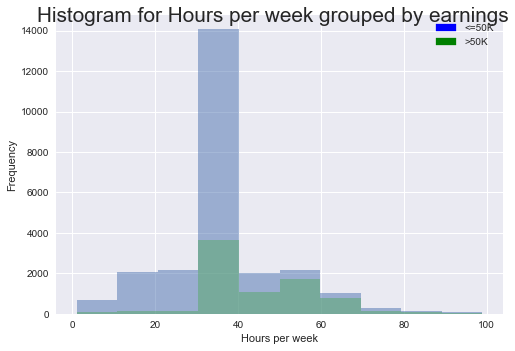

In [28]:
df.groupby('earnings').hours_per_week.hist(alpha=0.5)
plt.suptitle('Histogram for Hours per week grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Hours per week')
plt.ylabel('Frequency')
blue_patch = mpatches.Patch(color='blue', label='<=50K')
green_patch=mpatches.Patch(color='green', label=">50K")
plt.legend(handles=[blue_patch,green_patch])

The histograms for both groups here have a normal distribution with mean close to 40 hours a week.

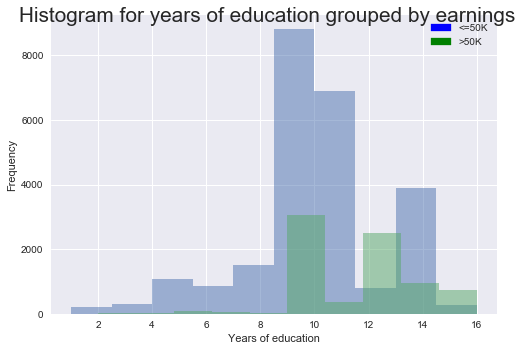

In [29]:
df.groupby('earnings').education_num.hist(alpha=0.5)
plt.suptitle('Histogram for years of education grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Years of education')
plt.ylabel('Frequency')
blue_patch = mpatches.Patch(color='blue', label='<=50K')
green_patch=mpatches.Patch(color='green', label=">50K")
plt.legend(handles=[blue_patch,green_patch])

The histogram for both the groups have a similar distribution. The histograms are not normal, they are left skewed.

earnings          <=50K  >50K
workclass                    
Federal-gov       589    371 
Local-gov         1476   617 
Never-worked      7      0   
Private           17692  4959
Self-emp-inc      494    622 
Self-emp-not-inc  1815   724 
State-gov         945    353 
Unknown           1645   191 
Without-pay       14     0   


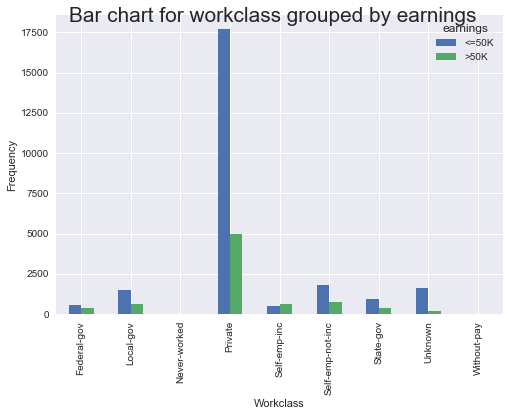

In [30]:
workclass = pd.crosstab(df.workclass, 
                       df.earnings)
print(workclass)
workclass.plot(kind='bar')
plt.suptitle('Bar chart for workclass grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Workclass')
plt.ylabel('Frequency')

The bar chart shows that the people who are employed by a private company tend to earn >50K at a greater rate than all of the other categories. All of the other categories have a higher rating for people earning <=50K.

earnings      <=50K  >50K
education                
10th          871    62  
11th          1115   60  
12th          400    33  
1st-4th       159    6   
5th-6th       315    16  
7th-8th       604    40  
9th           487    27  
Assoc-acdm    802    265 
Assoc-voc     1021   361 
Bachelors     3130   2221
Doctorate     107    306 
HS-grad       8814   1673
Masters       762    959 
Preschool     49     0   
Prof-school   153    423 
Some-college  5888   1385


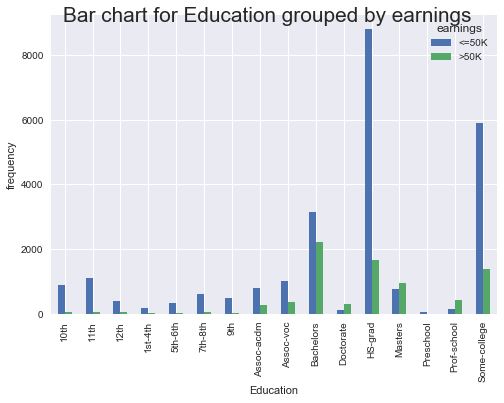

In [31]:
education = pd.crosstab(df.education, 
                       df.earnings)
print(education)
education.plot(kind='bar')
plt.suptitle('Bar chart for Education grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Education')
plt.ylabel('frequency')

The bar chart shows that individuals who have a doctorate, a professional school degree and a Master's degree have a higher rate of earning >50K than the rest of the categories. The people having a 1st-4th education have the lowest occurrence of earning >50K salary.

earnings               <=50K  >50K
marital_status                    
Divorced               3976   463 
Married-AF-spouse      13     10  
Married-civ-spouse     8276   6688
Married-spouse-absent  384    34  
Never-married          10161  491 
Separated              959    66  
Widowed                908    85  


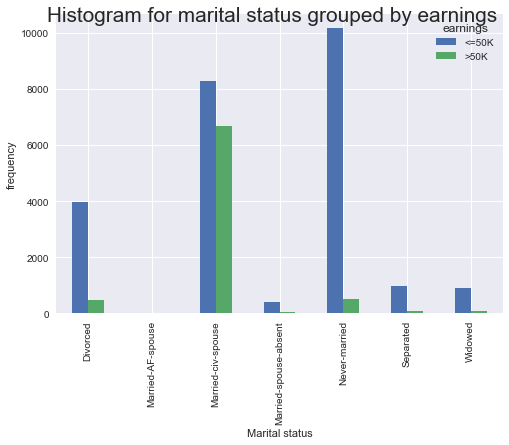

In [32]:
marital_status = pd.crosstab(df.marital_status, 
                       df.earnings)
print(marital_status)
marital_status.plot(kind='bar')
plt.suptitle('Histogram for marital status grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Marital status')
plt.ylabel('frequency')

The bar chart shows that married people have a higher instance of earning >50k than all the other categories.

earnings           <=50K  >50K
occupation                    
Adm-clerical       3259   507 
Armed-Forces       8      1   
Craft-repair       3160   929 
Exec-managerial    2096   1968
Farming-fishing    875    115 
Handlers-cleaners  1282   86  
Machine-op-inspct  1750   248 
Other-service      3150   137 
Priv-house-serv    145    1   
Prof-specialty     2275   1857
Protective-serv    438    211 
Sales              2667   983 
Tech-support       643    283 
Transport-moving   1277   320 
Unknown            1652   191 


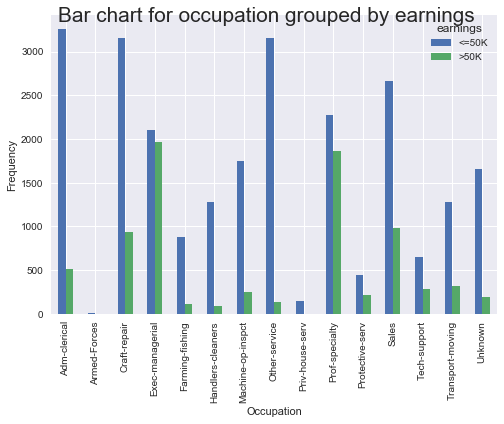

In [33]:
occupation = pd.crosstab(df.occupation, 
                       df.earnings)
print(occupation)
occupation.plot(kind='bar')
plt.suptitle('Bar chart for occupation grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('Occupation')
plt.ylabel('Frequency')

The bar chart shows that the people having a Exec-managerial job or a prof-speciality job have a higher rating of earning >50K than the other categories. The priv-house-serv job and handlers-cleaners job have the least rating for earning >50k.

earnings        <=50K  >50K
relationship               
Husband         7267   5914
Not-in-family   7424   856 
Other-relative  944    37  
Own-child       4993   67  
Unmarried       3226   218 
Wife            823    745 


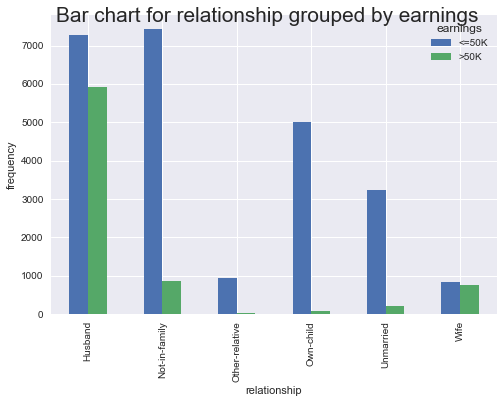

In [34]:
relationship = pd.crosstab(df_train.relationship, 
                       df.earnings)
print(relationship)
relationship.plot(kind='bar')
plt.suptitle('Bar chart for relationship grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('relationship')
plt.ylabel('frequency')

The bar chart shows that a husband and a wife has the highest rating to earning >50K as opposed to Other-relative and Own-child which have the least rating.

earnings                    <=50K  >50K
native_country                         
Cambodia                    12     7   
Canada                      82     39  
China                       55     20  
Columbia                    57     2   
Cuba                        70     25  
Dominican-Republic          68     2   
Ecuador                     24     4   
El-Salvador                 97     9   
England                     60     30  
France                      17     12  
Germany                     94     44  
Greece                      21     8   
Guatemala                   58     3   
Haiti                       40     4   
Honduras                    12     1   
Hong                        14     6   
Hungary                     10     3   
India                       60     40  
Iran                        25     18  
Ireland                     19     5   
Italy                       48     25  
Jamaica                     71     10  
Japan                       38     24  


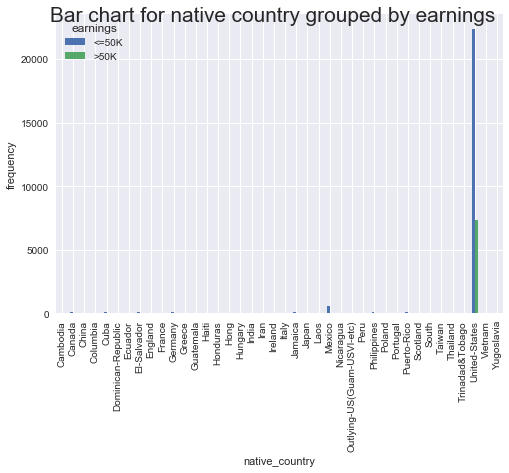

In [35]:
native_country = pd.crosstab(df.native_country, 
                       df.earnings)
print(native_country)
native_country.plot(kind='bar')
plt.suptitle('Bar chart for native country grouped by earnings', x=0.5, y=0.9, ha='center', fontsize='xx-large')
plt.xlabel('native_country')
plt.ylabel('frequency')

The dataset has a lot of observations for the United-stated category as compared to the other categories. Hence, making interpretations based on the bar chart is not apppropriate due to insufficient data.

### Multivariate Relationships

To assess multivariate relationships between features, we used:
* Grid of bivariate scatterplots
* Correlation matrix 
* Violin plot showing interactions between variables 

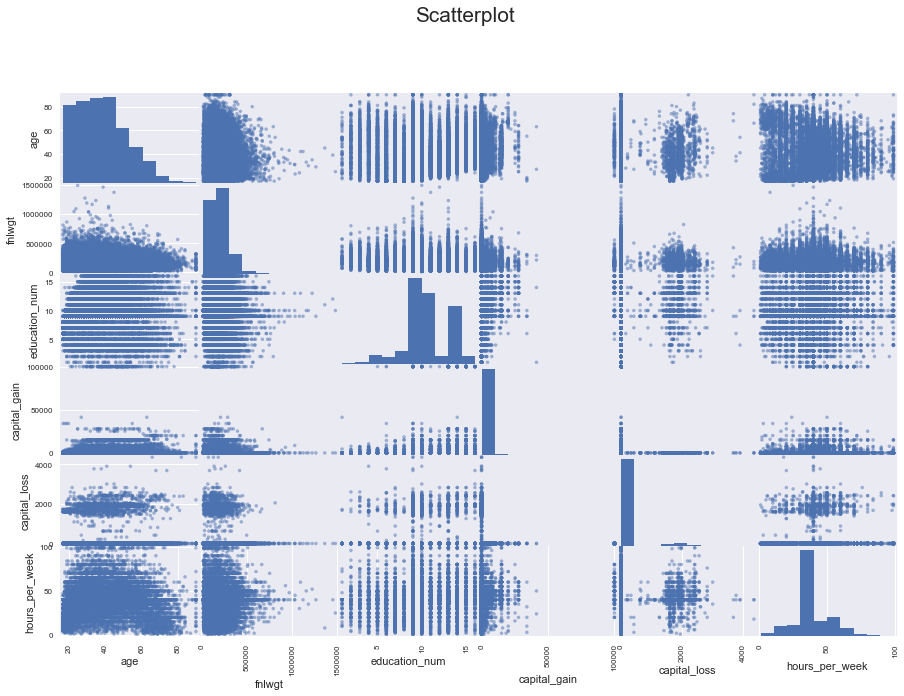

In [36]:
from pandas.tools.plotting import scatter_matrix

ax = scatter_matrix(df,figsize=(15, 10))

plt.suptitle('Scatterplot', x=0.5, y=1, ha='center', fontsize='xx-large')

The scatterplot includes all continuous features. None of the continuous features seem to move in tandem with other features, so we can infer that the continuous features are uncorrelated with each other.

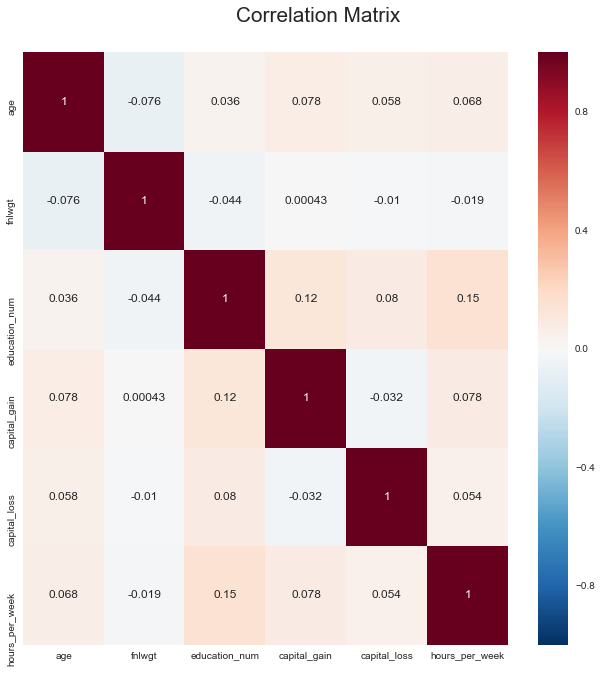

In [37]:
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9,9))

sns.heatmap(df.corr(), annot=True)

f.tight_layout()

plt.suptitle('Correlation Matrix', x=0.5, y=1.05, ha='center', fontsize='xx-large')

The correlation matrix provides further verification to our inference about the correlation. As seen above, the continuous features have very low correlations with one another. Education_num and hours_per_week have the maximum correlation of 0.15. Since the correlation is not significantly large, we do not need to worry about variance inflation, which would occur if one or more features were highly correlated with one another.

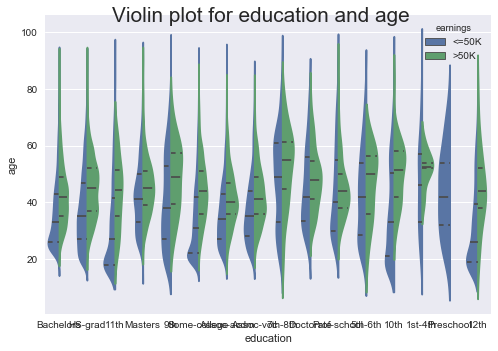

In [38]:
    sns.violinplot(x="education", y="age", hue="earnings", data=df, 
               split=True, inner="quart")
    plt.suptitle('Violin plot for education and age', x=0.5, y=0.9, ha='center', fontsize='xx-large')

For people earning <=50K, the distributions for the various education classes are different, as is the case with >50K. Hence, there may be interaction between these two features.

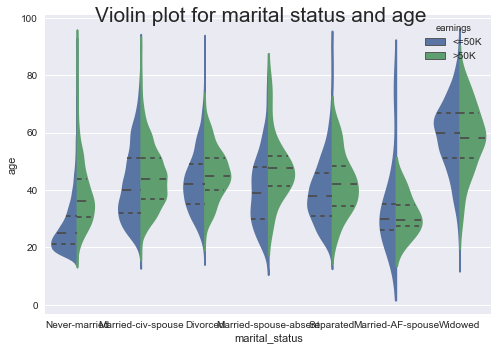

In [39]:
sns.violinplot(x="marital_status", y="age", hue="earnings", data=df, 
               split=True, inner="quart")
plt.suptitle('Violin plot for marital status and age', x=0.5, y=0.9, ha='center', fontsize='xx-large')

The distributions for the two groups are different for the various categories. Hence, there could be interaction between the two features.

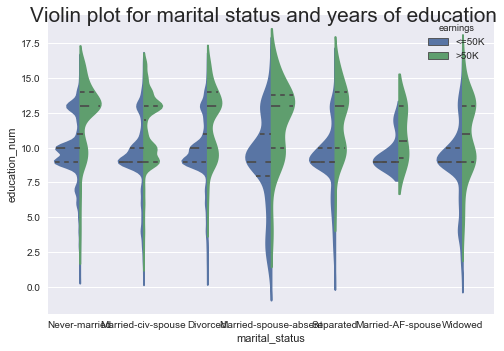

In [40]:
sns.violinplot(x="marital_status", y="education_num", hue="earnings", data=df, 
               split=True, inner="quart")
plt.suptitle('Violin plot for marital status and years of education', x=0.5, y=0.9, ha='center', fontsize='xx-large')

The vioin plots show differences in the distributions for both the groups for the different categories, indicating that there might be interaction between the two features.

## Dimensionality Reduction

The data is not particularly suited for numerical dimensionality reduction, as (a) it is not a particularly high dimensional data set, and (b) the features together exhibit fairly low multicollinearity. In spite of this, we perform dimensionality reduction by clustering based on demographic characteristics. We then compare these results with the feature *final weight*, since the description of the final weight in the data dictionary indicates that it is intended to represent demographic characteristics.

The steps we generally followed were:
1. Generate a design matrix, keeping the continuous variables and one-hot encoding all of the categorical variables.
2. Scale everything so that the minimum is zero and the maximum is one.
4. Utilize a k-means cluster with 10 clusters on the matrix.
5. Sample 200 observations from that matrix.
6. Plot the Pearson correlation matrix, excluding earnings, weights and clusters.
7. Preserve the previous order, plot a matrix that shows groups of rows with similar earnings.
8. Order the data by final weight and repeat steps 5 and 6.
9. Order the data by demographic cluster and repeat steps 5 and 6.
10. Check for patterns and to see if the entropy decreased when ordered by finalweight or demographic cluster.


The top matrix represents the correlation between rows, where we can see that all rows are positively correlated, with virtually no negatively correlated observations.
Basically, the bottom matrix tells us how similar the salaries are from observation to observation, the main idea of which was to plot them and see if there were many groups of white space (equal salaries) when ordered by different things.

In [42]:
scaler = preprocessing.MinMaxScaler()

df_demographic = pd.get_dummies(df.drop(["capital_gain", "capital_gain_group",
                                         "capital_loss", "capital_loss_group",
                                         "fnlwgt",
                                         "hours_per_week", "earnings"], axis=1))

df_demographic = scaler.fit_transform(df_demographic)

kmeans = KMeans(n_clusters=10).fit(df_demographic)
clusters = kmeans.labels_

In [43]:
df_plot = pd.get_dummies(df.drop(["capital_gain_group", "capital_loss_group", "hours_per_week_group","earnings"], axis=1))
df_plot["cluster"] = clusters
df_plot["earnings_>50K"] = pd.Categorical(df.earnings).codes


df_plot[df_plot.select_dtypes(include = ["int64"]).columns] = scaler.fit_transform(df_plot.select_dtypes(include = ["int64"]))
df_plot = df_plot.sample(300, axis=0)

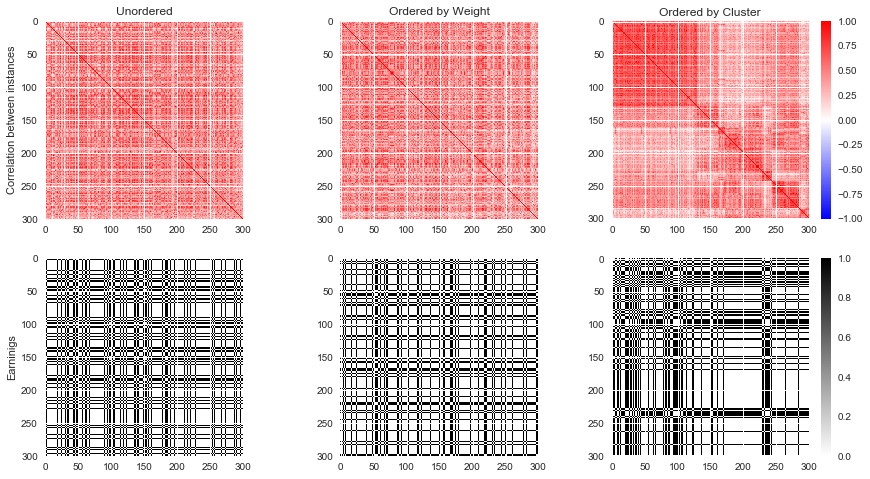

In [44]:
def print_distance_matrix(data, distance="euclidean"):
    if distance == "pearsonr":
        distance = lambda column1, column2: stats.pearsonr(column1, column2)[0]
        cmap="bwr"
        clim = (-1, 1)
    else:
        distance = lambda column1, column2: pd.np.linalg.norm(column1 - column2)   
        cmap="binary"
        clim = (0,1)
        
    cormat = data.apply(
        lambda col1: data.apply(
            lambda col2: distance(col1, col2), axis = 1), axis = 1)
    plt.imshow(cormat, cmap=cmap, clim=clim)         
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

#UNORDERED PLOT
a = plt.subplot(2,3,1)
im = print_distance_matrix(df_plot.drop(["earnings_>50K", "fnlwgt", "cluster"], axis=1), "pearsonr")
a.set_title("Unordered")
a.set_ylabel("Correlation between instances")
a = plt.subplot(2,3,2)
#PLOT SORTED BY FINAL WEIGHT
im = print_distance_matrix(df_plot.sort_values("fnlwgt").drop(["earnings_>50K", "fnlwgt", "cluster"], axis=1), "pearsonr")
a.set_title("Ordered by Weight")
a = plt.subplot(2,3,3)
#PLOT SORTED BY CLUSTERS
im = print_distance_matrix(df_plot.sort_values("cluster").drop(["earnings_>50K", "fnlwgt", "cluster"], axis=1), "pearsonr")
a.set_title("Ordered by Cluster")
plt.colorbar()
a = plt.subplot(2,3,4)
a.set_ylabel("Earninigs")
im = print_distance_matrix(pd.DataFrame(df_plot["earnings_>50K"]), "euclidean")
a = plt.subplot(2,3,5)
im = print_distance_matrix(pd.DataFrame(df_plot.sort_values("fnlwgt")["earnings_>50K"]), "euclidean")
a = plt.subplot(2,3,6)
im = print_distance_matrix(pd.DataFrame(df_plot.sort_values("cluster")["earnings_>50K"]), "euclidean")
plt.colorbar()
plt.show()

We notice some patterns when ordering the observations by survey weight and demographic clusters, but it is more noticeable when it is ordered by demographic cluster.

We can notice some local entropy loss of the response variable when ordering the data demographic cluster compared to when it is ordered by weight.

But do our demographic clusters represent the same as the weight survey? And more importantly, is survey weight representative of the demographics?

The following scatter plot show that, in reality, the clusters and the survey weight do not behave similarly. All clusters contain all ranges of survey weights. Since our clusters were defined by the demographic feaures, final weight may be representing something different that we are not accounting for.

The outcome is that we should reduce the dimension of our data by compressing every demographic feature to our clusters. We then can compare model performance with and without the lower dimensional representation of the data set.

We would suggest to use survey weight with caution as we do not really know if it is a characteristic we could use to predict earnings.

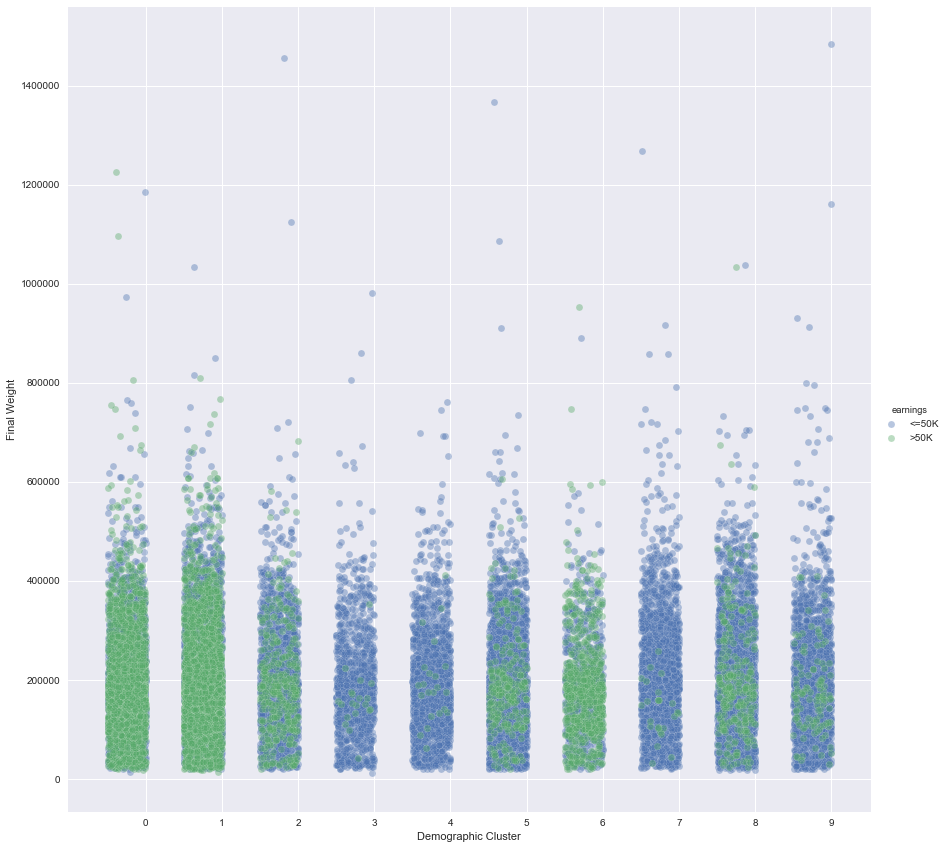

In [45]:
df_plot = df
df_plot["cluster"] = clusters+np.random.rand(len(df_plot))/2

g = sns.pairplot(x_vars = ["cluster"],  y_vars = ["fnlwgt"],
             data = df_plot,
             hue = "earnings",
             plot_kws={'alpha':0.4},
             size =12)
plt.xlabel("Demographic Cluster")
plt.ylabel("Final Weight")
g.set(xticklabels = np.unique(clusters), xticks = np.arange(0.5,10.5))
      #yticklabels = df.capital_loss_group.cat.categories, yticks = [0.25, 1.25, 2.25, 3.25])
plt.show()

After all of the preprocessing steps, the data set appears as below.

In [46]:
df_final = df.drop(["capital_gain", "capital_loss", "hours_per_week", "cluster"], axis = 1)
df_final.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,native_country,earnings,capital_gain_group,capital_loss_group,hours_per_week_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,small gain,no loss,full-shift
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,no gain,no loss,less than half-shift
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K,no gain,no loss,full-shift
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K,no gain,no loss,full-shift
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K,no gain,no loss,full-shift
